### Wavefront Calibration

Thus far, our examples have made two important assumptions:

- The SLM is perfectly in the Fourier domain without aberration, connected to the imaging domain via Fourier transform, and
- The optical amplitude of the source beam covers the SLM uniformly.

Generally, in practical experiments, both assumptions are **false**.

- Beamline misalignment, defocus, or imperfect optics will cause [optical aberration](https://en.wikipedia.org/wiki/Optical_aberration).
- The source beam will generally be Gaussian, and cannot cover the SLM uniformly without significant loss.

In this example, we will make use of functions and calibrations built into `slmsuite` to:

- Correct for optical aberration, such that phase profiles can be displayed with compensation, and
- Measure the sourced amplitude, such that GS-type optimization algorithms use a better base approximation the system (see `slmsuite.holography.algorithms`).

#### Initialization

To start, we initialize our system consisting of a camera and a SLM separated by a Fourier transform.

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

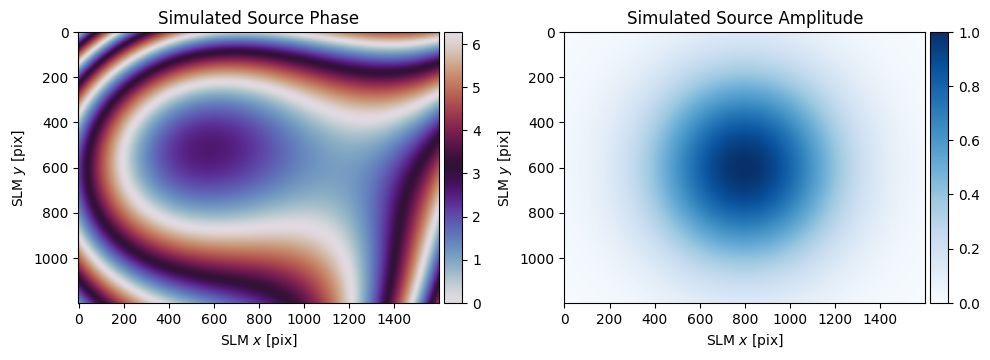

In [2]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the Simple Holography section.
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1600, 1200), pitch_um=(8,8))
phase_abberation = zernike_sum(
    slm,
    indices=(3, 4, 5, 7, 8),
    weights=(1, -2, 3, 1, 1),
    aperture=None,
    use_mask=False
)
slm.set_source_analytic(                        # Program the virtual source.
    phase_offset=phase_abberation,
    sim=True
)
slm.plot_source(sim=True)
slm.set_source_analytic()

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", fliplr=True)
fs = FourierSLM(cam, slm)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn '02C5V' initializing... success


We also make a helper function which we will use to display results:

In [4]:
def plot(title="", cam_limits=.25):
    _, axs = plt.subplots(1, 3, figsize=(16,4))

    if "phase" in slm.source:
        correction = np.mod(slm.source["phase"], 2*np.pi)
    else:
        correction = 0 * slm.phase

    plt.sca(axs[0]); fs.slm.plot(correction, title="Phase Correction", cbar=False)
    plt.sca(axs[1]); fs.slm.plot(slm.phase, title="Displayed Phase", cbar=True)
    plt.sca(axs[2]); fs.cam.plot(title="Camera Result", limits=cam_limits, cbar=True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Without Wavefront Calibration

An uncalibrated SLM will generally not achieve diffraction-limited performance. For instance, some SLMs possess inherent curvature, which must be calibrated for ideal operation. We can take a look at this aberration, as seen below on a Santec SLM:

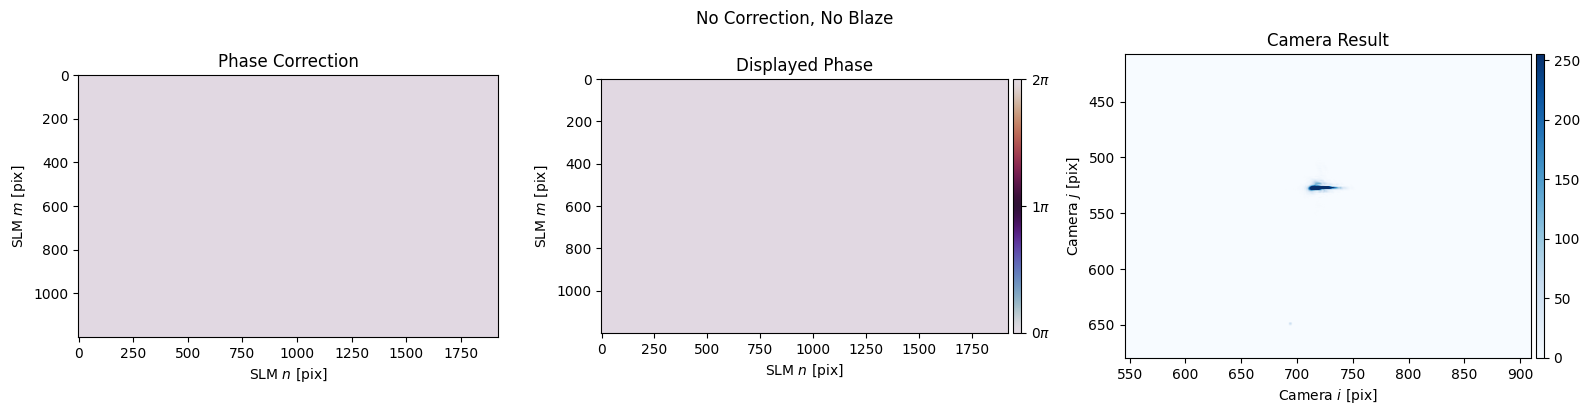

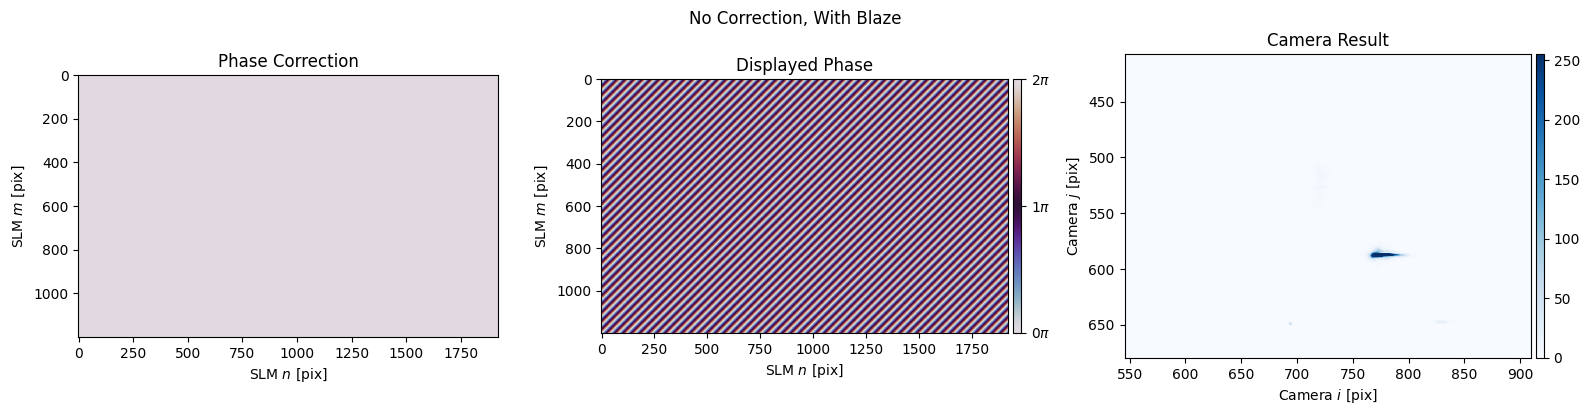

In [5]:
cam.set_exposure(.002)
slm.source.pop("phase", None)

slm.write(None, settle=True)
plot(title="No Correction, No Blaze")

slm.write(blaze(grid=slm, vector=(.002, .002)), settle=True)
plot(title="No Correction, With Blaze")

#### Vendor Phase Calibration

Some vendors provide phase calibration data for the wavefront of their SLMs, usually acquired by [Shack-Hartmann](https://en.wikipedia.org/wiki/Shack%E2%80%93Hartmann_wavefront_sensor) wavefront sensing. Subclasses implementing a vendor's SDK can also support the `SLM.load_vendor_phase_calibration()` function to interpret the file provided by the vendor (`.csv` in the case of Santec):

In [6]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading the phase correction!
# If you're using virtual hardware, use this cell to upload the correct wavefront calibration:
slm.source["phase"] = -phase_abberation

In [7]:
slm.read_vendor_phase_correction(
    file_path='Wavefront_correction_Data_221136000005(830nm).csv',  # Update this path to load your calibration
    smooth=True
);

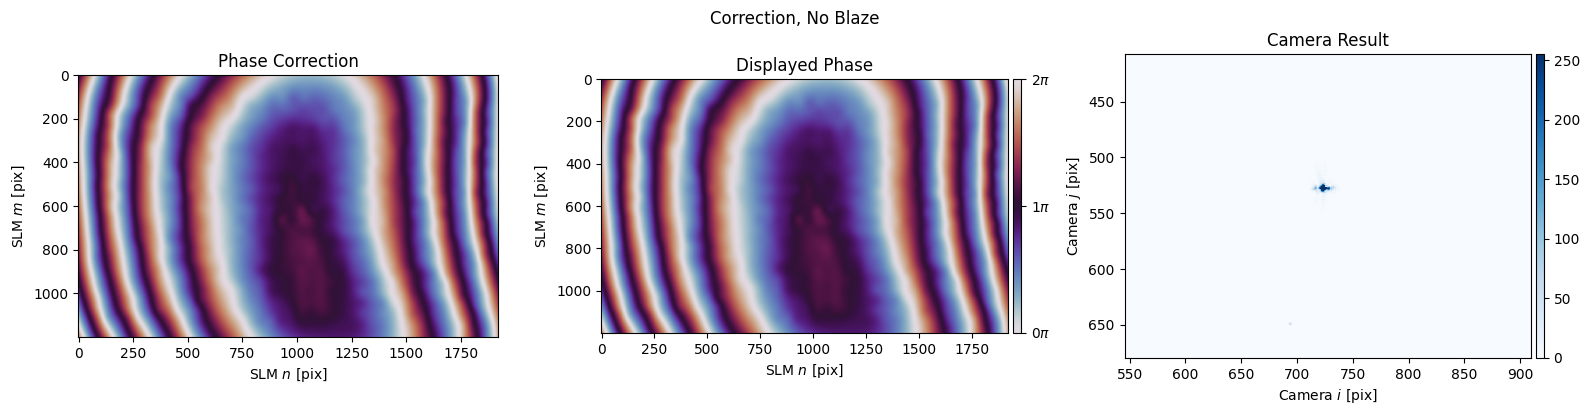

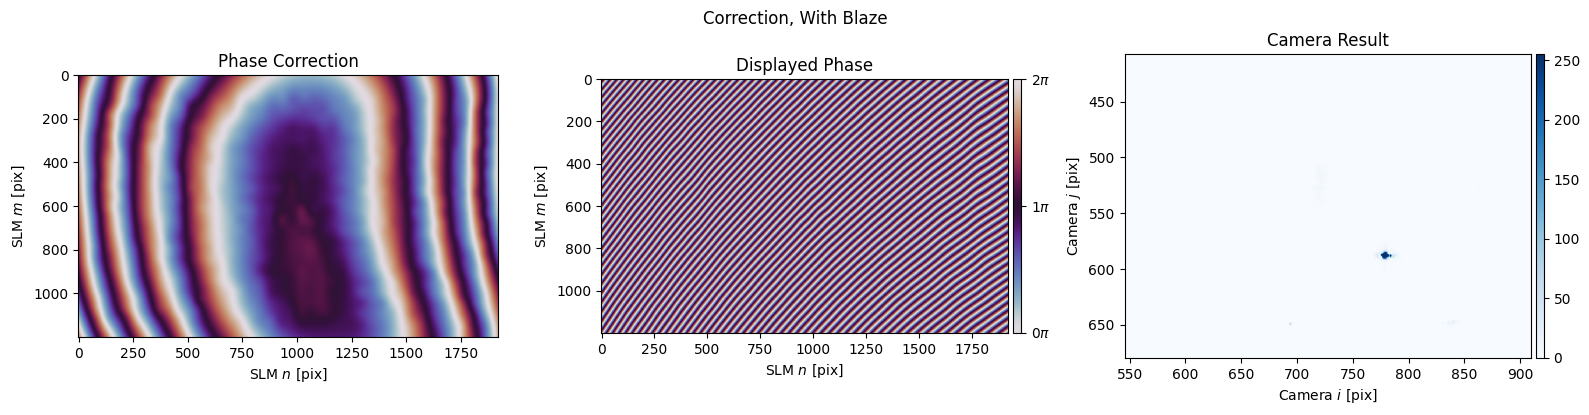

In [8]:
slm.write(None, settle=True)
plot(title="Correction, No Blaze")

slm.write(blaze(grid=slm, vector=(.002, .002)), settle=True)
plot(title="Correction, With Blaze")

Immediately, we see an improvement: rather than observing a distorted spot, we see one that is approximately diffraction limited. If a user knows the approximate focal length of a curved SLM, but does not have a calibration, a `toolbox.phase.lens` phase pattern can be loaded to the `.phase_calibration` attribute of the SLM as an analytic proxy.

Still, we can do better. The vendor-provided data only corrects for aberration on the SLM, but knows nothing of other beamline aberrations related to our setup. Additionally, information regarding source amplitude is valuable for holography. Calibrating these values, as aforementioned, is the goal of `FourierSLM.wavefront_calibrate()`.

#### Fourier Calibration

The automated wavefront calibration routines which are part of `slmsuite` are conducted through camera feedback. For this to work, we first need to calibrate the camera's Fourier domain (see Experimental Holography). Note that in this case, it is critical to apply some form of phase correction before calibrating, as otherwise the spots in the Fourier calibration grid would be sufficiently diffraction limited to resolve a grid.

  0%|          | 0/10 [00:00<?, ?it/s]

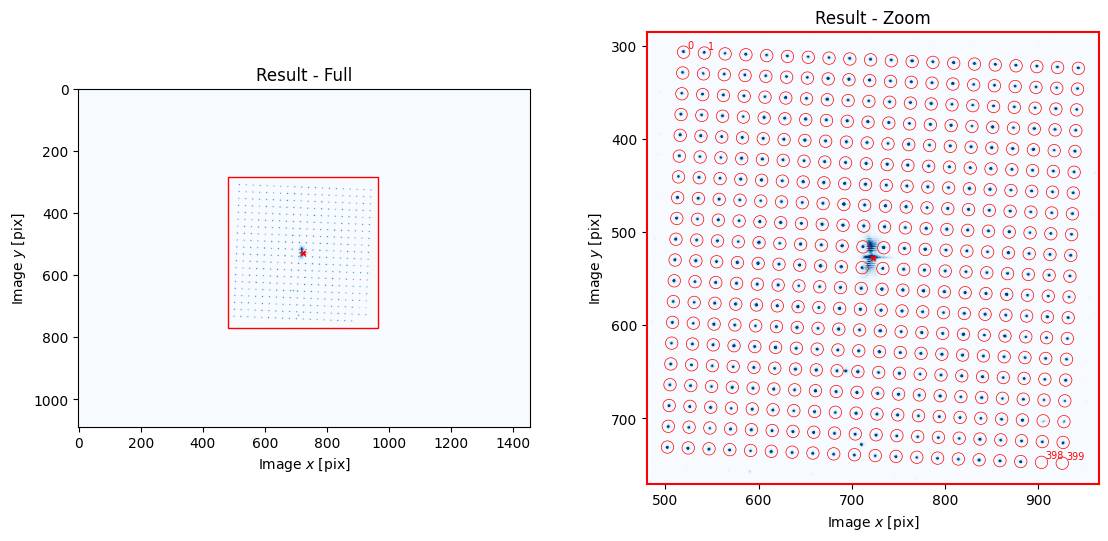

{'M': array([[28849.68728418, -1177.46104178],
        [ 1179.785244  , 28855.78792947]]),
 'b': array([[722.7096653],
        [527.5166606]]),
 'a': array([[-8.76122968e-21],
        [ 5.60718699e-19]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-25 14:31:11.002326',
 '__timestamp__': 1721932271.002326,
 '__meta__': {'camera': '02C5V', 'slm': '2018021001'}}

In [9]:
cam.set_exposure(.05)

fs.fourier_calibrate(
    array_shape=20,                 # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=20,                 # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

#### Testing Wavefront Calibration

Now we are ready for wavefront calibration. This is a 
[serial process](https://doi.org/10.1038/nphoton.2010.85) where 'superpixels'
on the SLM of size `superpixel_size`$\times$`superpixel_size` pixels are tested one
after another. We are looking to measure, as mentioned in the introduction, two things:

- A local phase correction factor about each superpixel, to counteract optical aberration, and
- A measurement of the optical amplitude at each superpixel. 

We can measure these by:

- Interfering a given superpixel with some reference superpixel (chosen by default to be at the center of the SLM). A fit to the resulting interference fringes yields a measurement of the phase correction needed to bring the given superpixel into the same Fourier plane as the reference superpixel.
- Integrating the power (amplitude squared) confined in the diffraction order corresponding to the superpixel.

`FourierSLM.wavefront_calibrate()` is designed with a testing feature, such that when the `test_superpixel` keyword is passed, the user is provided with helper plots to make sure that calibration is working at the superpixel corresponding to `test_superpixel`. Shown below is the result for the superpixel with index `(16, 16)`, where superpixels are zero-indexed from the origin coordinate of the SLM. If one looks closely at the phase, small square superpixels can be seen where power is diffracted into a different order. Note the titles of the plots which explain the purpose of each step in this process. The final returned dictionary contains the data that will be gathered from each superpixel on the SLM.

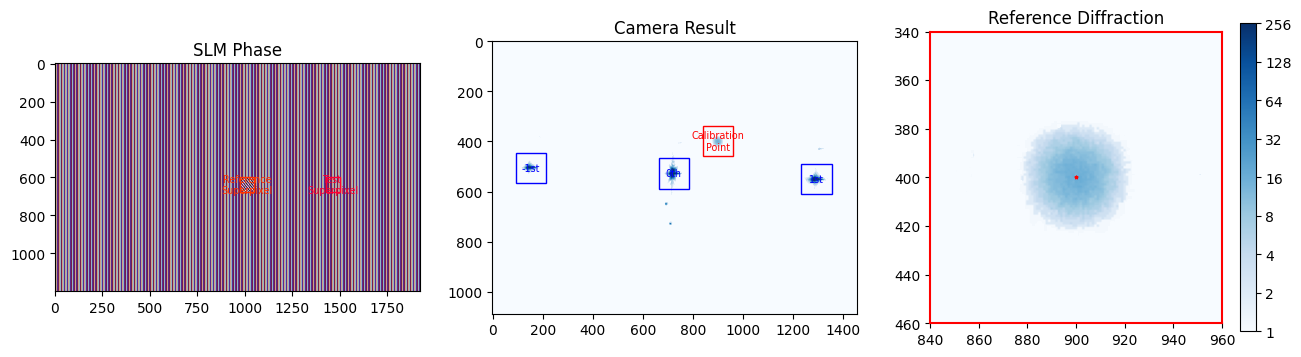

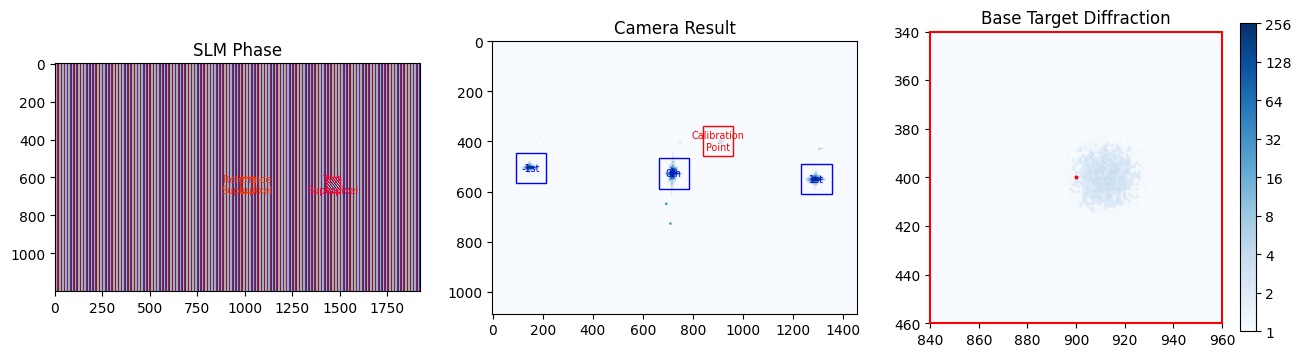

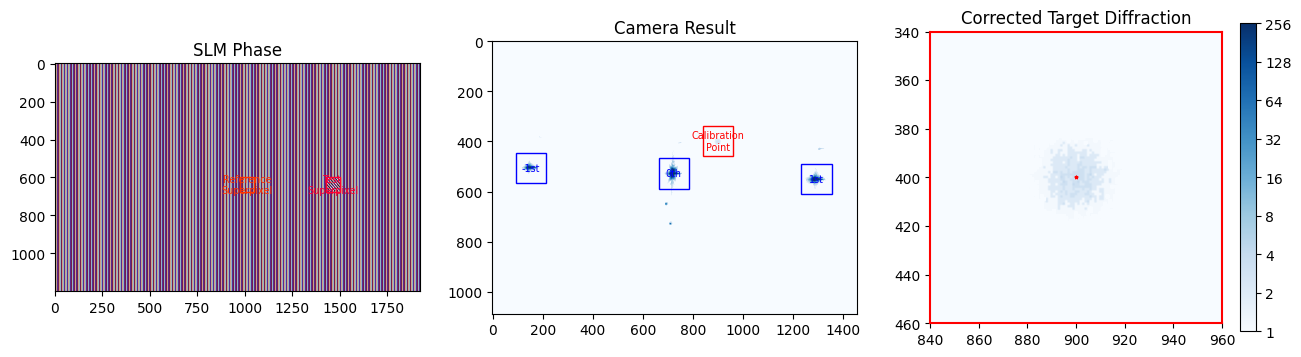

phase_measurement:   0%|          | 0/10 [00:00<?, ?it/s]

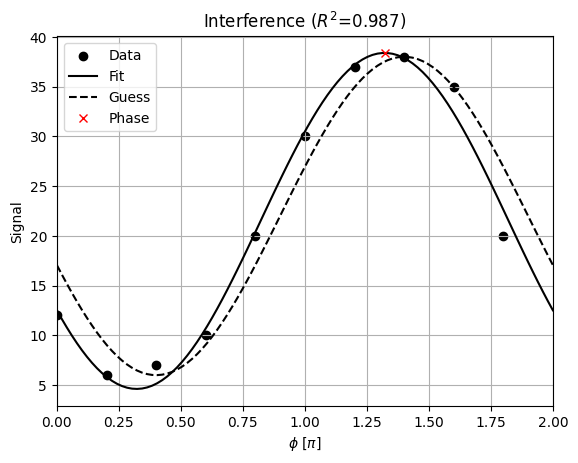

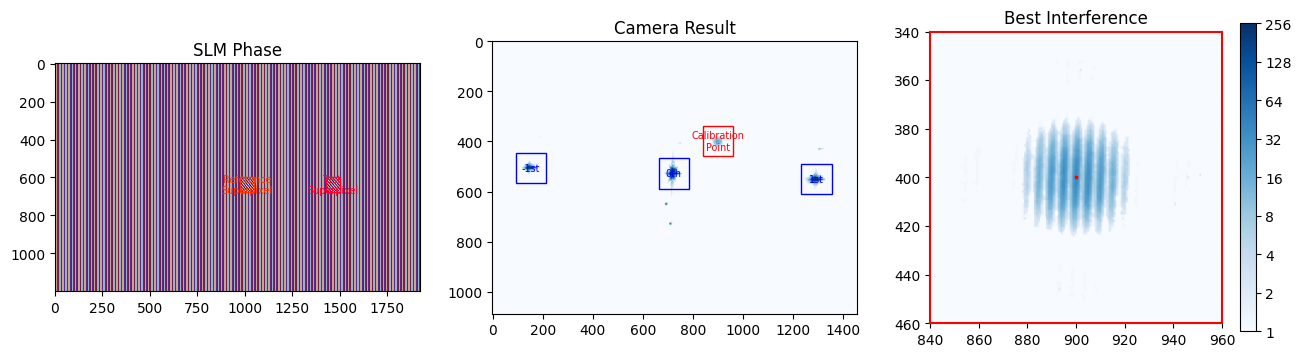

In [10]:
cam.set_exposure(.1)
movie = fs.wavefront_calibrate(
    calibration_points=(900, 400),
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=75,
    corrected_amplitude=True,
    test_index=5,                       # Testing mode
    phase_steps=10,                     # Special mode to step through phase for the .gif
    plot=3                              # Special mode to generate a phase .gif
)

from slmsuite.holography.analysis.files import write_image

write_image("wavefront.gif", movie)

We use markdown to display the .gif we just made:

![Phase Movie](wavefront.gif)

The diffracted spot resulting from these rectangular superpixels matches their Fourier transform: the amplitude of a rectangular [sinc](https://en.wikipedia.org/wiki/Sinc_function) function.

Note that this function returns the result of calibration on a given superpixel, where `'power'`, `'normalization`, and `'background'` deal with parameters relevant to amplitude calibration, and other parameters—especially `'phase'`, `'kx'`, and `'ky'`—are relevant for phase calibration.

Testing allows the user to hone parameters for more ideal calibration, specifically:

- `calibration_points`, the point in the camera's `"ij"` basis where interference takes place.
    - As the plural implies, `slmsuite` can simutaneously calibrate at many points, but for this tutorial we just feed one point.
    - The `calibration_points` should be far from sources of noise, especially the ordered diffraction peaks of the field which contain the vast majority of the optical power in the system.
    - Wavefront calibration works best in a region around each of the `calibration_points`. The extent of this region depends on the parameters of the optical system and the nature of the aberrations.
- `field_point`, the point in the camera's `"ij"` basis where the field (power not in a superpixel) is deflected towards.
    - This is useful because it reduces the power in the 0th order. This should be chosen such that higher diffraction orders from the field are far away from the `calibration_points`.
- Camera exposure.
    - If the user does not use the `autoexposure` parameter (which sets the maximum exposure of the camera to be 10% of the dynamic range), then the user should make sure that calibration does not overexposure the camera during the calibration process. This might involve trying different `test_superpixel` superpixels to test superpixels with higher or lower power.
- `superpixel_size`, the size in SLM pixels of each superpixel.
    - In general, this should be chosen to be a small as reasonable within SNR and time constraints.
    - Ideally, it would also be a divisor of both the width and height of the SLM, so there are no cropped superpixels.
- `test_superpixel`, the superpixel used to test (described above).
    - The user should be sure to try a few test across the SLM domain, to make sure that calibration is working well for a variety of conditions. Especial care—as mentioned in the camera exposure section—should be taken to avoid overexposure, so the user should be sure to test bright `test_superpixel` superpixels to probe these regimes.

#### Wavefront Calibration

With calibration working on this test case, we proceed to do this process over the full SLM. Removing the `test_superpixel` keyword disables testing mode and begins a long (roughly two hours, in this example) serial process of testing each superpixel. `tqdm` bars monitor progress for user feedback (though these are not visible in the final notebook, as the `leave` keyword is used).

In [11]:
cam.set_exposure(.1)
fs.wavefront_calibrate(
    calibration_points=(900, 400),
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=75
);

calibration:   0%|          | 0/415 [00:00<?, ?it/s]

We should save the data immediately after this this 15 min measurement.

In [12]:
fs.write_calibration("wavefront_superpixel")

'C:\\Users\\Experiment\\Documents\\GitHub\\slmsuite-examples\\examples\\02C5V-2018021001-wavefront_superpixel-calibration_00002.h5'

#### Processing Wavefront Calibration

The raw data from wavefront calibration is stored and saved in a condensed form, where a few numbers for each superpixel is recorded. To use this data, we need to process the information on a per-pixel basis, rather than per-superpixel. This is done by `FourierSLM.process_wavefront_calibration()`. There are a few options available to the user for honing the calibration processing.

- `r2_threshold` sets the threshold for which bad fits are ignored. Notice below that there is significant clipping in the domain of the SLM. Within the clipped region, the fits are good, but outside it's clear that it's just noise. The threshold `r2_threshold` can be adjusted to omit or include superpixels at the user's preference. There are a few adaptive features to guess what the phase would look like in noise superpixels close to superpixels that are above threshold. Noise pixels outside of this are given a flat phase propagating out from the center.
- `smooth` adds blurring to the final result to smooth out the discretization caused by the superpixel approach. This will yield better results in practice as it avoids discontinuities between superpixels.

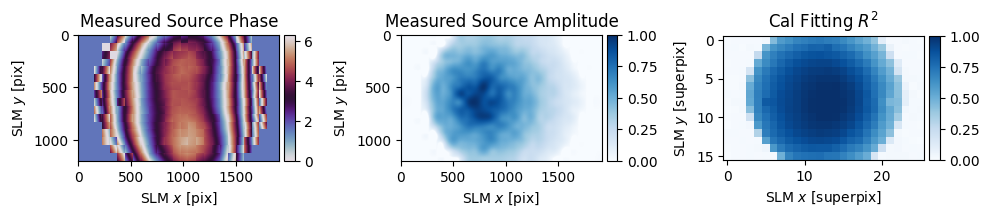

In [13]:
# Without smoothing
fs.wavefront_calibration_superpixel_process(r2_threshold=.25, smooth=False, plot=True);

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

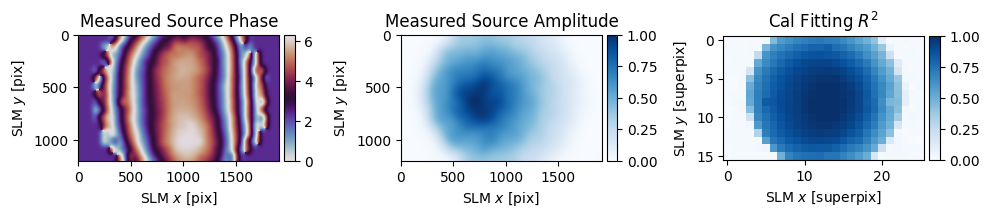

In [14]:
# With smoothing
fs.wavefront_calibration_superpixel_process(r2_threshold=.25, smooth=True, plot=True);

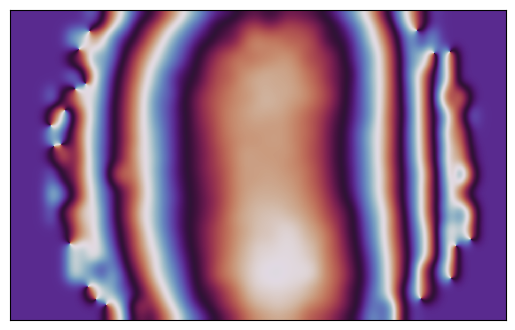

In [15]:
# Make a plot for the thumbnail.
plt.imshow(fs.slm.source["phase"], cmap='twilight', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()